# Mg diffusion in plagioclase model 
## Finite Difference Method Approach to the Diffusion Equation in 1D 
*Jordan Lubbers* <br>
*College of Earth, Ocean, and Atmospheric Sciences* <br>
*Oregon State University*


Utilizes the forward difference scheme to the finite difference method for Fick's $2^{nd}$ Law

While the diffusion coefficient of Mg in plagioclase are compositionally dependent (i.e. the rate at which it diffuses within the plagioclase crystal lattice decreases with increasing An content), the partitioning of trace elements into plagioclase is also An dependent and follows an Arrhenius relationship (e.g. Bindeman et al., 1998; Dohmen and Blundy, 2014; Nielsen et al., 2017). Costa and others (2003; Eq. 7) derive a solution to the diffusion equation that incorporates this:
\begin{equation}\label{costa_eq}
\frac{\delta C}{\delta t} = \left(\frac{\delta D}{\delta x}\frac{\delta C}{\delta x}+D\frac{\delta^2C}{\delta x^2}\right) - \frac{A}{RT}\left(D\frac{\delta C}{\delta x}\frac{\delta X_{An}}{\delta x}+C\frac{\delta D}{\delta x}\frac{\delta X_{An}}{\delta x}+DC\frac{\delta^2X_{An}}{\delta x^2} \right) 
\end{equation}
\
We can see here that the first part of the equation deals with the diffusion of matter, and the second part of the equation pertains to the Arrhenius partitioning relationship. Discretizing this equation we get the following:
\begin{equation}\label{plag_FD}
C_{i,j+1} = C_{i,j} + \Delta t\Bigg\{\left[\left(\frac{D_{i+1,j}-D_{i,j}}{\Delta x}\right)\left(\frac{C_{i+1,j}-C_{i,j}}{\Delta x}\right)+D_{i,j}\left(\frac{C_{i+1,j}-2C_{i,j}+C_{i-1,j}}{\Delta x^2}\right)\right] - \frac{A}{RT}\left[ D_{i,j}\left(\frac{C_{i+1,j}-C_{i,j}}{\Delta x}\cdot\frac{An_{i+1,j}-An_{i,j}}{\Delta x}\right)+C_{i,j}\left(\frac{D_{i+1,j}-D_{i,j}}{\Delta x}\cdot\frac{An_{i+1,j}-An_{i,j}}{\Delta x}\right)+D_{i,j}C_{i,j}\left(\frac{An_{i+1,j}-2An_{i,j}+An_{i-1,j}}{\Delta x^2}\right)\right]\Bigg\}
\end{equation}

- $C_{i,j+1}$ is the concentration of a trace element at a point in space $i$ and time $j$
- $D_{i,j+1}$ is the diffusion coefficient of a trace element at a point in space $i$ and time $j$
- $An_{i,j}$ is the anorthite of the plag a point in space $i$ and time $j$
- $\Delta t$ is the time spacing between $j$ steps
- $\Delta x$ is the distance spacing between $i$ steps.
- $A$ is the constant from Nielsen et al., (2017) for $Mg$ partitioning in plagioclase
- $R$ and $T$ are the universal gas constant $8.314 \frac{J}{mol\cdot K}$ and temperature in Kelvin, respectively

## Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.interpolate as interp
import seaborn as sns
from scipy import stats

## Import data 
This is how I format my data: each column is a variable (e.g., analyte) and each row is an individual observation (e.g., concentration of said analyte at a given spot in a transect). For the code below to work there should be one column that denotes which grain a transect came from. You can call it whatever you want but ultimately this helps delineate between different transects. 

In [2]:
filepath = "path/to/mydata.xlsx"
sheet_name = "plagioclase trace profiles"
mydata = pd.read_excel(filepath, sheet_name=sheet_name,)
mydata.head()

,index,grain,sample,spot,location,pumice type,An,Li,Mg,Si,...,Si_se,Ca_se,Ti_se,Fe_se,Sr_se,Ba_se,La_se,Ce_se,Eu_se,Pb_se
0,272,MQ2,MQ,MQ2-LT-readyspot0,rim,banded,0.428469,14.182287,59.847871,264729.067093,...,4612.456707,948.287042,19.816264,40.177845,10.361437,5.428762,0.311744,0.285490,0.073922,0.953166
1,273,MQ2,MQ,MQ2-LT-readyspot1,rim,banded,0.402673,12.186312,54.506839,267569.625241,...,4683.859089,889.788913,18.311831,40.254044,9.886144,5.375988,0.305544,0.298061,0.085942,0.989139
2,274,MQ2,MQ,MQ2-LT-readyspot2,rim,banded,0.373036,13.505803,56.124201,271426.082654,...,4424.407389,822.603271,17.202320,38.423881,9.401607,5.101791,0.291372,0.266983,0.078428,1.086601
3,275,MQ2,MQ,MQ2-LT-readyspot3,rim,banded,0.389422,14.483002,56.472904,269206.011004,...,4189.466220,859.746452,17.768755,38.537895,9.393451,5.203899,0.287544,0.296493,0.070561,1.113580
4,276,MQ2,MQ,MQ2-LT-readyspot4,rim,banded,0.395573,13.779702,55.497519,268430.006433,...,4274.631948,873.690346,17.768394,38.664305,9.597920,5.127188,0.279626,0.303730,0.074639,1.084794


# Set Index
This allows us to better access our data by which transect it belongs to 
1. Set the plag dataframe index by grain. This then allows us to index that dataframe by transect
2. Get list of grains so you can index in the next step

In [3]:
plag_bygrain = mydata.set_index("grain")
plag_grains = list(plag_bygrain.index.unique())
print(plag_grains)

['MQ2', 'MQ3', 'MQ6core', 'MQ6rim', 'MQ7', 'MQ8', 'MQ9', 'MQ11', 'MQ12', 'MQ13', 'MQ14rim', 'MQ15', 'MQ17core', 'MQ17rim', 'MQ18core', 'MQ18rim', 'MQ19', 'MQ20core', 'MQ20rim', 'MQ21rim', 'MQ22', 'MQ23', 'MQ24core', 'MQ24int', 'MQ24rim', 'MQ25', 'MQ26', 'MQ27int', 'MQ27rim', 'MQ29', 'MQ31', 'MQ32', 'MQ33', 'MQ34', 'LT1', 'LT2', 'LT5', 'LT8', 'LT9', 'LT10', 'LT12', 'LT17', 'LT18', 'LT19', 'LT22']


## Set up initial Model range
Here you can choose which element you want to model (choose Mg because that's what the diffusion model is set up to do), it's uncertainty, and which grain (transect) you want to model it for.
- The ```start``` and ```stop``` variables are for the index of the profile you want to start and stop the model at. This is reflected by the green markers in the plot

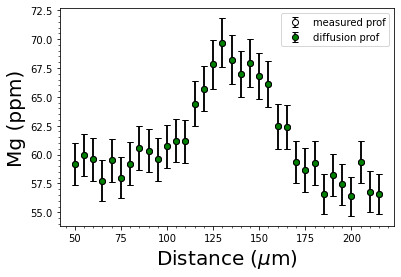

In [4]:
element = "Mg"
unc = "Mg_se"
grain = "MQ2"
# the domain you wish to model diffusion over
start = 0
stop = 0
# spatial resolution in microns
res = 5

# measured trace element information
te_all = plag_bygrain.loc[grain, element].to_numpy()
te_unc_all = plag_bygrain.loc[grain, unc].to_numpy()
An_all = plag_bygrain.loc[grain, "An"].to_numpy()


# distance data
dist_all = np.arange(0, len(plag_bygrain.loc[grain, :])) * res

# this is if you want to clip any erroneous points from the ends of your data
clip_start = 10

clip_stop = len(te_all) - 1


dist_all = dist_all[clip_start:clip_stop]
te_all = te_all[clip_start:clip_stop]
te_unc_all = te_unc_all[clip_start:clip_stop]
An_all = An_all[clip_start:clip_stop]

te = te_all[start : len(te_all) - stop]
te_unc = te_unc_all[start : len(te_all) - stop]
dist = dist_all[start : len(te_all) - stop]


# plot observed data
fig, ax = plt.subplots(figsize=(6, 4))
# observed profile and subset
ax.errorbar(
    dist_all,
    te_all,
    yerr=te_unc_all,
    fmt="o",
    mfc="w",
    mec="k",
    ecolor="k",
    capsize=3,
    label="measured prof",
)
ax.errorbar(
    dist,
    te,
    yerr=te_unc,
    fmt="o",
    mfc="g",
    mec="k",
    ecolor="k",
    capsize=3,
    label="diffusion prof",
)
ax.legend(loc="best")
ax.set_ylabel("{} (ppm)".format(element), fontsize=20)
ax.set_xlabel("Distance ($\mu$m)", fontsize=20)
ax.minorticks_on()

## Generating random points based off your measured values and the uncertainty at each point in the profile
Because your analysis value is technically the mean value associated with a normally distributed uncertainty, it has a chance to be a range of values with the probability of a given value governed by a normal distribution centered around your analysis value. To better reflect this, we can generate a 'random profile' where new points are picked at each analysis point according to the reported uncertainty at each point.

In order to generate this random point based off our measured value and analytical uncertainty we can use the [```numpy.random.normal```](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)function that generates a normally distributed random number if given the mean and standard deviation. This is a viable function to use becaue if our measurements are subjected to small random errors and negligible systematic errors, the distribution of measurements taken will be normal centered around the mean.

We will use this later in our Monte Carlo simulation to estimate the uncertainty in our diffusion model

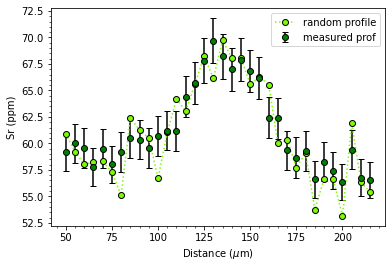

In [5]:
# random profile from your y and yerr
def random_profile(x, y, yerr):
    """random_profile generates a random observed profile for diffusion modeling that is based of the measured value 
    and its corresponding uncertainty at each point. 
            Inputs:
            x = x data 
            y = y data
            yerr = 1 sigma uncertainty on y data measurements. If your data has 2 sigma uncertainties, just 
            create a new variable that divides it by 2 so you have 1 standard deviation uncertainties
            
            Returns:
            yrand = random y data points who's liklihood is normally distributed around the mean"""
    import numpy as np

    # np.random.normal(mean,std deviation)
    yrand = np.random.normal(loc=y, scale=yerr)
    return yrand


yrand = random_profile(dist, te, te_unc)
fig, ax = plt.subplots(figsize=(6, 4))
# observed profile
ax.errorbar(
    dist,
    te,
    yerr=te_unc,
    fmt="o",
    mfc="g",
    mec="k",
    ecolor="k",
    capsize=3,
    label="measured prof",
)
# random profile
ax.plot(
    dist, yrand, ":o", c="lawngreen", mec="k", label="random profile",
)
ax.legend(loc="best")
ax.set_ylabel("Sr (ppm)")
ax.set_xlabel("Distance ($\mu$m)")
ax.minorticks_on()

## Constants, equilibrium trace element profile, diffusion coefficient profile
Here we define 
- temperature of our model
- universal gas constant (R)
- activation energy for the diffusion coefficient of Mg in plag
- thermodynamic parameters from Nielsen et al 2017 for Mg partitioning in plagioclase
- Mg glass composition. THIS IS SPECIFIC TO YOUR SYSTEM

We then use the partitioning parameters, temperature, and glass composition to calculate what the profile would look like if it were fully equilibrated with a magma that has a composition identical to the glass values we used. Since this usually comes from pumice, we're justified in this being the most accurate representation of the magma chemistry at the time of eruption. We also set up an An array from 0 to 1 and use taht combined with the partitioning parameters to calculate a range of compositions that, based on An, our Mg data should fall into if it is equilibrated. The slope of this curve is very important, as it shows that if our profile is equilibrated, Mg should be increasing with decreasing An. If it is not equilibrated then it will have the opposite relationship

In [6]:
# Constants
T_K = 750 + 273.15  # temp in K
# Ea = 266e3  # J/mol
R = 8.314  # gas constant in J/mol*K

# anorthite
An = An_all[start : len(te_all) - stop]


# Thermodynamic constants for Mg partitioning in plagiocase [DO NOT CHANGE]
# [average,max,min] 1sigma
a_Mg = np.array([-10000, -10000 + 3300, -10000 - 3300])  # from Nielsen et al., 2017
b_Mg = np.array([-35000, -35000 + 2100, -35000 - 2100])

An_partition = np.arange(
    0.1, 1.1, 0.1
)  # range of anorthite compositions to calculate equilibrium curves

# glass compositions [ppm] averages
# this is specific to your magma system!
Mg_gl = 450

# Mg partition coefficients [DO NOT CHANGE]
D_Mg_ave = np.exp(((a_Mg[0] * An_partition) + b_Mg[0]) / (R * T_K))
D_Mg_max = np.exp(((a_Mg[1] * An_partition) + b_Mg[1]) / (R * T_K))
D_Mg_min = np.exp(((a_Mg[2] * An_partition) + b_Mg[2]) / (R * T_K))

# Calculated Mg equilibrium  [DO NOT CHANGE]
Eq_Mg_ave = Mg_gl * D_Mg_ave
Eq_Mg_max = Mg_gl * D_Mg_max
Eq_Mg_min = Mg_gl * D_Mg_min


# Mg equilibrium profile based off the relationships found in Nielsen et al., (2017)
# partition coefficient at each point based on An concentration
Kd = np.exp((a_Mg[0] * An_all + b_Mg[0]) / (R * T_K))

# if we assume that the rim most point is in equilibrium with the liquid:
# concentration of liquid
Cl = te[-1] / Kd[-1]
Eq_prof_all = Cl * Kd
Eq_prof = Eq_prof_all[start : len(te_all) - stop]

## Plot up your equilibrium, anorthite, and trace element profiles 
This is just plotting the stuff defined and calculated above

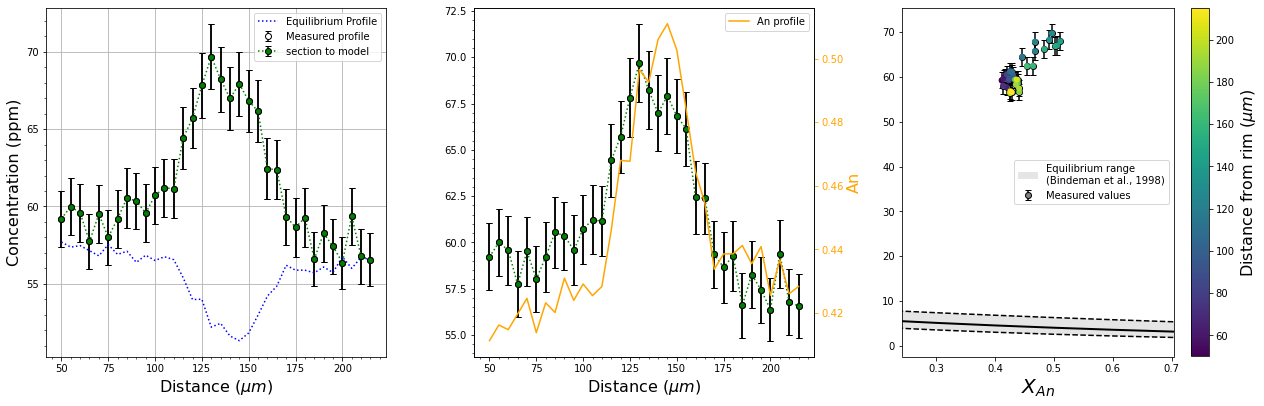

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
fig.patch.set_facecolor("white")
# entire trace element profile
ax[0].errorbar(
    dist_all,
    te_all,
    yerr=te_unc_all,
    fmt="o",
    mfc="w",
    mec="k",
    c="gray",
    ecolor="k",
    capsize=3,
    label="Measured profile",
)
# part of the profile you are modeling
ax[0].errorbar(
    dist,
    te,
    yerr=te_unc,
    fmt=":o",
    mfc="g",
    mec="k",
    c="g",
    ecolor="k",
    capsize=3,
    label="section to model",
)
# entire equilibrium profile
ax[0].plot(dist_all, Eq_prof_all, ":b", mec="k", label="Equilibrium Profile")

ax[0].set_xlabel("Distance ($\mu m$)", fontsize=16)
ax[0].set_ylabel("Concentration (ppm)", fontsize=16)
ax[0].legend(loc="best")
ax[0].minorticks_on()
ax[0].grid()

# entire trace element profile
ax[1].errorbar(
    dist_all, te_all, yerr=te_unc_all, fmt="o", mfc="w", mec="k", ecolor="k", capsize=3,
)
# part of the profile you are modeling
ax[1].errorbar(
    dist, te, yerr=te_unc, fmt=":o", mfc="g", mec="k", c="g", ecolor="k", capsize=3
)
ax[1].set_xlabel("Distance ($\mu m$)", fontsize=16)
ax[1].minorticks_on()
# ax[1].set_ylim(top = 60)

# secondary axis for An profile
ax3 = ax[1].twinx()
color3 = "orange"
ax3.plot(dist_all, An_all, "-", c=color3, label="An profile")
ax3.tick_params(axis="y", colors=color3)
ax3.set_ylabel("An", fontsize=16, color=color3)
ax3.yaxis.label.set_color(color3)
ax3.legend(loc="best")

# An vs Mg for your entire profile with error bars
ax[2].errorbar(
    An_all,
    te_all,
    yerr=te_unc_all,
    fmt="o",
    mec="k",
    ecolor="k",
    color="gray",
    capsize=3,
    label="Measured values",
    zorder=1,
)
# plotting An vs Mg but colored for distance so that you can
# have errorbars and this info on the same plot. This is needed
# because plt.errorbar is based off plt.plot not plt.scatter
s = ax[2].scatter(
    An_all, te_all, marker="o", c=dist_all, cmap="viridis", ec="none", zorder=2
)
cbar = fig.colorbar(s, ax=ax[2],)
cbar.set_label("Distance from rim ($\mu m$)", fontsize=16)

# fill between the equilibrium range bounds
ax[2].fill_between(
    An_partition,
    Eq_Mg_min,
    Eq_Mg_max,
    fc="gray",
    zorder=0,
    alpha=0.2,
    label="Equilibrium range \n(Bindeman et al., 1998)",
)
# plot the equilibrium range lines
ax[2].plot(An_partition, Eq_Mg_min, "k--")
ax[2].plot(An_partition, Eq_Mg_max, "k--")
ax[2].plot(An_partition, Eq_Mg_ave, "k-", lw=2)


ax[2].legend(loc="best")
ax[2].set_xlabel("$X_{An}$", fontsize=20)
ax[2].set_xlim(np.min(mydata["An"]) * 0.9, np.max(mydata["An"]) * 1.2)
# ax[2].set_ylim(np.min(Eq_Mg_min),np.max(Eq_Mg_max))

fig.tight_layout(pad=2)

## Setting up Diffusion model 
Here is where we start to establish boundary conditions for our diffusion model. But first we must tweak a couple things. Namely, we are going to interpolate our profiles so that things are spaced closer together. This allows us a couple advantages:
1. Numerical stability that is defined as $\frac{D\Delta t}{\Delta x^2}$
2. Smoothing out our An profile a little bit

Per the advice of Sumit Chakraborty, 
> Anorthite gradients are often very sharp, and particularly if one analytical point falls off the trend, it has a huge (negative) impact on the calculations - usually, that error multiplies with each iteration and leads to unusual numbers. A trick is the following - "diffuse"  and smoothen the Anortite gradient a little bit artificially

First we create some interpolating functions for our distance, An, trace element, and random trace element profiles. We then apply those interpolating functions to an x-grid that has ```multiplier```x as many points as our observed distance spacing.

We then create an array that will be the length of total time we want the diffusion model to run for spaced by the $\Delta t$ we want. With Mg I usually have a $\Delta t$ spaced by 'days'. This is actually the amount of seconds in a day. Since our diffusion coefficient is in units of $\frac{um^2}{s}$, our model time needs to also be in seconds. We can convert this to a meaningful time later. The total duration of the diffusion model is specified by:
```python
iterations = int(3.65e3)   
sinyear = 60*60*24*365.25
days = sinyear/365.25

t = np.arange(0,iterations*days+1,days)      
```
and states that we are going to run the model for ```3.65e3``` years, and spaced by the amount of seconds in one day. 

Next we need to set up our initial boundary condition. We can do this by creating some containers:
```python
#containers for each iteration
#unknown at current iteration  
u = np.zeros(nx)     
#u at previous iteration
u_n = np.zeros(nx)                          
```
```u_n``` in the beginning will be our boundary condition, so we then fill that with values that we think the profile may start at. Because An diffuses so slowly in plagioclase relative to Mg, this can be a good reference for the width and height of your initial profile. This code is set up to do up two double sided step functions. If you believe you have that in your profile just un-comment the part of the code that would define the second double sided step function. To define our initial profile:
```python
#these numbers are the actual distance in microns
#we convert them to their index in the array later
stepstart = 60 - np.min(dist)
stepstop = 95 - np.min(dist)
```
These values are where you think your step should start on either side. If you only have a one sided step function, then just make the step stop value larger than your maximum distance value.
```python
#boundary conditions in ppm for left, middle, and right
Cl = 55
Cm = 73
Cr = 50
```
These are the Mg values for the boundary conditions
```python
step_begin = stepstart
step_begin_idx = int(step_begin/dx)
step_stop = stepstop
step_stop_idx = int(step_stop/dx)
```
This part finds the index that step starts and stops at in your profile. This is needed to later fill in the ```u_n``` container with boundary condition values.

```python
u_n[:step_begin_idx] = Cl
u_n[step_begin_idx:step_stop_idx] = Cm
u_n[step_stop_idx:] = Cr
```
This now uses the indices you just found for where your step is to say that "everything left of the step fill with the left boundary condition, everything between the step fill with the middle boundary condition, and everything right of the step fill with the right boundary condition". We now have created our initial condition for diffusion to start at! There is also the option to interpolate between two points defined as left and right boundary conditions to make an initial boundary condition that is not a "step function". For that we just uncomment the ```Cm``` line to be: 

```python

# first step function
u_n[:step_begin_idx] = Cl
u_n[step_begin_idx:step_stop_idx] = np.interp(
    x[step_begin_idx:step_stop_idx],
    np.array((x[step_begin_idx], x[step_stop_idx])),
    np.array((Cl, Cr)),
)
# u_n[step_begin_idx:step_stop_idx] = Cm
u_n[step_stop_idx:] = Cr
```



We then can repeat this for as many steps as we want by just copy and pasting the steps that define our ```Cl, Cm, Cr```. We just have to name them something different (e.g., ```Cl2, Cm2, Cr2```. 

Because ```u_n``` will get re-written at each step of the model we make a copy of it to save as our initial step function:
```python
step_func = u_n.copy()  
```
We then diffuse the An profile slightly using an arbitrary ```r``` value of .2. For each iteration of the diffusion equation we save the value in the container ```an_curves```. This will allow us to access the values when the loop is done. We choose the third diffusion step so that the corners are rounded slightly but not too much so as to still keep the same shape. 

Once we have the smoothed out An profile we can calculate the diffusion coefficient for each step in the interpolated grid. We defined a function to do this above called ```diffusivity```, so we just use that here.

For more information about how to code up the diffusion equation in Python, see [Numerical Modeling of the Diffusion Equation Walkthrough](https://drive.google.com/file/d/1Tig0Ex6ZiVMGUX5Xusm2lfVL8LBtROBb/view?usp=sharing)

Text(0.1, 0.1, 't$_{20}$ = 2.11 yrs')

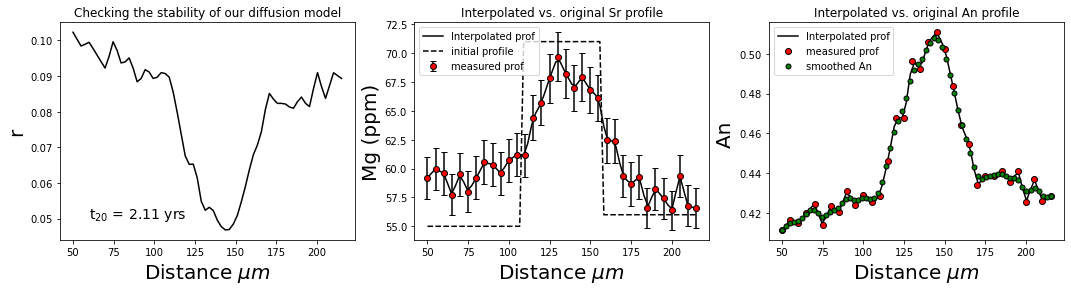

In [8]:
# interpolated profiles to 'smooth out' An profile steepness that may cause errors in the
# diffusion...per the advice of Sumit Chakraborty

# this multiplies the amount of of x points you have effectively 'filling in' your x grid
multiplier = 2
# setting up your finite difference with a specified number of x points
# here we are saying to add 5 times as many interpolated points as observed points

# number of points in your xgrid
nx = len(dist) * multiplier
# creating your xgrid
x = np.linspace(np.min(dist), np.max(dist), nx)
# x spacing
dx = x[1] - x[0]

# interpolated An profile
f_An = interp.interp1d(dist, An)
An_interp = f_An(x)

# interpolated te profile
f_te = interp.interp1d(dist, te)
te_interp = f_te(x)

# interpolated te profile
f_teunc = interp.interp1d(dist, te_unc)
teunc_interp = f_teunc(x)

f_rand = interp.interp1d(dist, yrand)
rand_interp = f_rand(x)


# since our Di is in um^2/s we need to factor that into our time grid
# by spacing out the points accordingly.
iterations = int(10 * 18250)
sinyear = 60 * 60 * 24 * 365.25
tenthsofyear = sinyear / 10
days = sinyear / 365.25
sinday = 60 * 60 * 24

# creating a time grid that is spaced by years
t = np.arange(0, iterations * tenthsofyear + 1, tenthsofyear)
dt = t[1] - t[0]
nt = len(t)


# containers for each iteration
# unknown at current iteration
u = np.zeros(nx)
# u at previous iteration
u_n = np.zeros(nx)


# initial condition as a step function
# these numbers are the actual distance in microns
# we convert them to their index in the array later
stepstart = 110 - np.min(dist)
stepstop = 160 - np.min(dist)

# boundary conditions in ppm for left, middle, and right
Cl = 55
Cm = 71
Cr = 56

step_begin = stepstart
step_begin_idx = int(step_begin / dx)
step_stop = stepstop
step_stop_idx = int(step_stop / dx)

# # IF THERE ARE TWO DOUBLE SIDED STEP FUNCTIONS IN ONE PROFILE
# stepstart2 = 160 - np.min(dist)
# stepstop2 = 190 - np.min(dist)
# Cl2 = Cr
# Cm2 = 70
# Cr2 = 62


# step2_begin = stepstart2
# step2_begin_idx = int(step2_begin/dx)
# step2_stop = stepstop2
# step2_stop_idx = int(step2_stop/dx)


# first step function
u_n[:step_begin_idx] = Cl
# u_n[step_begin_idx:step_stop_idx] = np.interp(
#     x[step_begin_idx:step_stop_idx],
#     np.array((x[step_begin_idx], x[step_stop_idx])),
#     np.array((Cl, Cr)),
# )
u_n[step_begin_idx:step_stop_idx] = Cm
u_n[step_stop_idx:] = Cr


# if there are two step functions use this bit instead of the Cr
# above
# u_n[step_stop_idx:step2_begin_idx] = Cr
# # u_n[step2_begin_idx:step2_stop_idx] = np.interp(
# #     x[step2_begin_idx:step2_stop_idx],
# #     np.array((x[step2_begin_idx], x[step2_stop_idx])),
# #     np.array((Cl2, Cr2)),
# # )
# u_n[step2_begin_idx:step2_stop_idx] = Cm2
# u_n[step2_stop_idx:] = Cr2


step_func = u_n.copy()

# creating a container to put all of your curve iterations
curves = np.zeros((nt, nx))


# diffuse the An profile a bit to get rid of the sharp corners
# Advice from Sumit Chakraborty himself...
# left and right boundary conditions
an_t = 100

An_l = An_interp[0]
An_r = An_interp[-1]

# arbitrary r value for diffusion. Just need to round the corners
# a small bit
r_an = 0.2

# unknown at current iteration
an_u = np.zeros(nx)


# make initial profile defined above our starting point for
# diffusion
an_u_n = An_interp.copy()


# creating a container to put all of your curve iterations
an_curves = np.zeros((an_t, nx))

# iterating over the length of nt(each iteration is a time step)
for n in range(0, int(an_t)):

    # diffusion equation with constant D. Runs over length of nt for each
    # r value
    an_u[1 : nx - 1] = an_u_n[1 : nx - 1] + r_an * (
        an_u_n[0 : nx - 2] - 2 * an_u_n[1 : nx - 1] + an_u_n[2:nx]
    )

    # fixing your boundary conditions with above values
    an_u[0] = An_l
    an_u[-1] = An_r
    # saving your iteration to your curve container
    an_curves[n, :] = an_u
    # switch your variables before the next iteration
    # makes your current u vals the u_n vals in the next loop
    an_u_n[:] = an_u
An_smooth = an_curves[2]

# Van Orman et al 2013 diffusion coefficient
# diffusivity in (um^2/s)
D_interp = np.exp(-6.06 - 7.96 * An_interp - 287e3 / (R * T_K)) * 1e12

r = (D_interp * dt) / dx ** 2


fig, ax = plt.subplots(1, 3, figsize=(18, 4))
ax[0].plot(x, r, "k-")
ax[0].set_ylabel("r", fontsize=20)
ax[0].set_xlabel("Distance $\mu m$", fontsize=20)
ax[0].set_title("Checking the stability of our diffusion model")

ax[1].plot(x, te_interp, "k-", label="Interpolated prof")
ax[1].errorbar(
    dist,
    te,
    yerr=te_unc,
    fmt="ro",
    mec="k",
    ecolor="k",
    capsize=3,
    label="measured prof",
)
ax[1].plot(x, step_func, "k--", label="initial profile")
# ax[1].plot(x,mg_init,
#            'b--',
#            label = 'mg_init'
# )


ax[1].set_ylabel("{} (ppm)".format(element), fontsize=20)
ax[1].set_xlabel("Distance $\mu m$", fontsize=20)
ax[1].set_title("Interpolated vs. original Sr profile")
ax[1].legend(loc="best")

ax[2].plot(x, An_interp, "k-", label="Interpolated prof")
ax[2].plot(
    dist, An, "ro", mec="k", label="measured prof",
)
ax[2].plot(
    x, An_smooth, "go", mec="k", ms=5, label="smoothed An",
)
ax[2].set_ylabel("An ", fontsize=20)
ax[2].set_xlabel("Distance $\mu m$", fontsize=20)
ax[2].set_title("Interpolated vs. original An profile")
ax[2].legend(loc="best")

t20 = (0.24 * (((dist[1] - dist[0]) * 1e-6) ** 2) / (D_interp / 1e12)) / sinyear

ax[0].text(
    0.1,
    0.1,
    "t$_{{20}}$ = {} yrs".format(np.round(t20.max(), 2)),
    transform=ax[0].transAxes,
    fontsize=14,
)

## Diffusion equation part
This is the coded up discretization of the equation at the top and follows the logic in in this [walkthrough](https://drive.google.com/file/d/1Tig0Ex6ZiVMGUX5Xusm2lfVL8LBtROBb/view?usp=sharing). 

In [9]:
# iterating over the length of Nt(each iteration is a time step)
for n in tqdm(range(0, int(nt))):
    # this is long...
    u[1 : nx - 1] = u_n[1 : nx - 1] + dt * (
        ((D_interp[2:nx] - D_interp[1 : nx - 1]) / dx)
        * ((u_n[2:nx] - u_n[1 : nx - 1]) / dx)
        + D_interp[1 : nx - 1]
        * ((u_n[2:nx] - 2 * u_n[1 : nx - 1] + u_n[0 : nx - 2]) / dx ** 2)
        - (a_Mg[0] / (R * T_K))
        * (
            D_interp[1 : nx - 1]
            * (
                ((u_n[2:nx] - u_n[1 : nx - 1]) / dx)
                * ((An_smooth[2:nx] - An_smooth[1 : nx - 1]) / dx)
            )
            + u_n[1 : nx - 1]
            * (
                ((D_interp[2:nx] - D_interp[1 : nx - 1]) / dx)
                * ((An_smooth[2:nx] - An_smooth[1 : nx - 1]) / dx)
            )
            + D_interp[1 : nx - 1]
            * u_n[1 : nx - 1]
            * (
                (An_smooth[2:nx] - 2 * An_smooth[1 : nx - 1] + An_smooth[0 : nx - 2])
                / dx ** 2
            )
        )
    )
    # letting the most 'core-ward' boundary condition diffuse according to the Costa 2003 equation
    u[0] = u_n[0] + dt * (
        ((D_interp[1] - D_interp[0]) / dx) * ((u_n[1] - u_n[0]) / dx)
        + D_interp[0] * ((u_n[1] - 2 * u_n[0] + u_n[1]) / dx ** 2)
        - (a_Mg[0] / (R * T_K))
        * (
            D_interp[0]
            * (((u_n[1] - u_n[0]) / dx) * ((An_smooth[1] - An_smooth[0]) / dx))
            + u_n[0]
            * (
                ((D_interp[1] - D_interp[0]) / dx)
                * ((An_smooth[1] - An_smooth[0]) / dx)
            )
            + D_interp[0]
            * u_n[0]
            * ((An_smooth[1] - 2 * An_smooth[0] + An_smooth[1]) / dx ** 2)
        )
    )

    # fix the most 'rim-ward' concentration (infinite reservoir assumption) based on observed data
    u[-1] = te_interp[-1]

    # #     infinite reservoir based on boundary condition fixed based on boundary conditions
    #     u[-1] = step_func[-1]

    # not infinite reservoir assumption. Let's everything diffuse and does not keep it fixed
    # potentially useful for grains that are not at the rim
    #     u[-1] = u_n[-1] +  dt*(((D_interp[-2] - D_interp[-1])/dx)*((u_n[-2]-u_n[-1])/dx) + D_interp[-1]*((u_n[-2]-2*u_n[-1]+u_n[-2])/dx**2)-(a_Mg[0]/(R*T_K))*(D_interp[-1]*(((u_n[-2]-u_n[-1])/dx)*((An_smooth[-2]-An_smooth[-1])/dx)) + u_n[-1]*(((D_interp[-2]-D_interp[-1])/dx)*((An_smooth[-2]-An_smooth[-1])/dx)) + D_interp[-1]*u_n[-1]*((An_smooth[-2]-2*An_smooth[-1]+An_smooth[-2])/dx**2)))

    # saving your iteration to your curve container
    curves[n, :] = u
    # switch your variables before the next iteration
    # makes your current u vals the u_n vals in the next loop
    u_n[:] = u


# Chi- squared minimization for best fit
chi2 = abs(np.sum((te_interp[None, :] - curves) ** 2 / (te_interp[None, :]), axis=1))

# find the minimum value
chi2_min = np.min(chi2)

# find where in the array it is (e.g., it's position)
fit_idx = np.argwhere(chi2 == chi2_min)

# Get that array index
fit_idx = fit_idx[0].item()

# add one because python starts counting at 0
bf_time = fit_idx + 1

  0%|          | 0/182501 [00:00<?, ?it/s]

## Plot it all up!
This is just plotting up all of your results:
1. Observed data with initial condition and best fit curve
2. Best fits vs. time
3. Observed data and An on same plot to show justification for intial boundary conditions
4. Mg vs. An data plotted up against equilibrium range based on assumed liquid composition and temperature

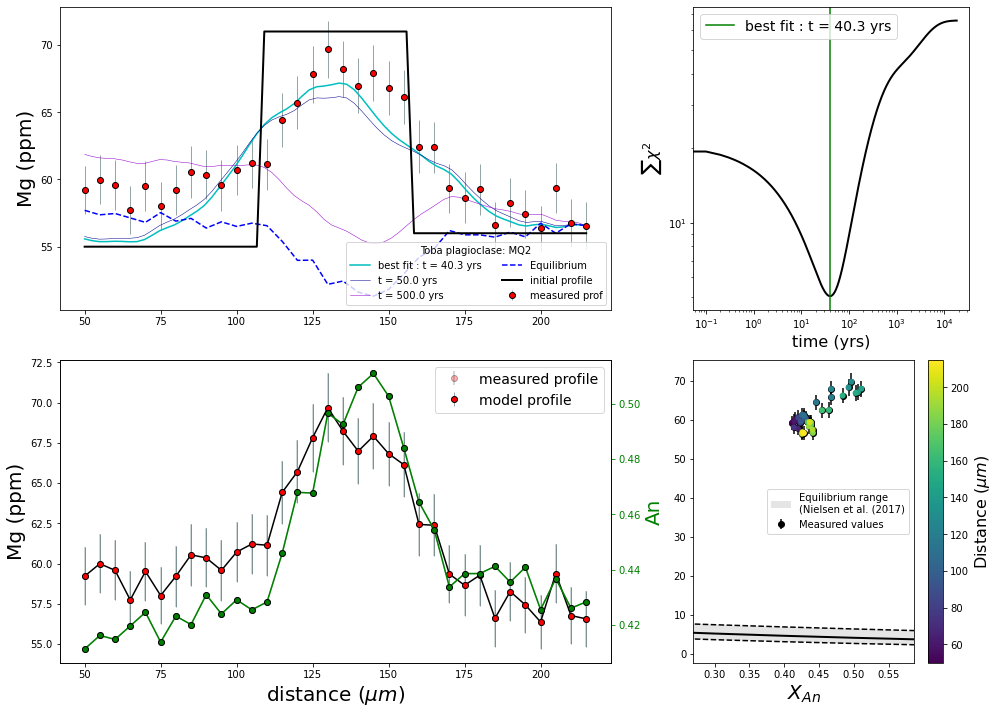

In [10]:
# these are just comparison time steps. I have them set for years but you can do it for whatever makes sense
# to your problem

# This converts your number of iterations to years
# eg if you are spacing by "sinyear", makeyears = 1
# if you are spacing by "tenthsofyear", makeyears = 10
# if you are spacing by "days", makeyears = 365


makeyears = 10
compare = np.array([50 * makeyears, 500 * makeyears,])

# color list for plotting
colors = ["darkblue", "darkviolet", "orange", "gray", "g"]

# make iterations to years we have to divide by 365 since we iterate in days


fig, ax = plt.subplots(
    2,
    2,
    figsize=(14, 10),
    gridspec_kw={"width_ratios": [2, 1], "height_ratios": [1, 1]},
)
# modeled section of profile
ax[0, 0].errorbar(
    dist,
    te,
    yerr=te_unc,
    fmt="ro",
    mec="k",
    ecolor="darkslategray",
    lw=0.5,
    capsize=0,
    label="measured prof",
)


# best fit curve
ax[0, 0].plot(
    x,
    curves[bf_time],
    "-",
    c="c",
    mec="k",
    label="best fit : t = {} yrs".format(np.round(bf_time / makeyears, 2)),
    lw=1.5,
)

# comparison curves. Omit this if you don't want them
for i in range(0, len(compare)):

    ax[0, 0].plot(
        x,
        curves[compare[i]],
        c=colors[i],
        label="t = {} yrs".format(compare[i] / makeyears),
        lw=0.5,
    )
# equilibrium profile
ax[0, 0].plot(dist, Eq_prof, "b--", label="Equilibrium")
# boundary conditions
ax[0, 0].plot(x, step_func, "-k", lw=2, label="initial profile")

# legend
# ax[0,0].legend(loc = 'best',
#                title='CGI plagioclase: {}\_{}\-{}'.format(grain.split('_')[0],grain.split('_')[1].split('-')[0],grain.split('_')[1].split('-')[1]),
#                prop={'size': 10},ncol = 2
# )
ax[0, 0].legend(
    loc="best", title="Toba plagioclase: {}".format(grain), prop={"size": 10}, ncol=2
)

ax[0, 0].set_ylabel("{} (ppm)".format(element), fontsize=20)
# ax[0,0].set_xlim(left = 0, right = np.max(x))
# ax[0,0].set_ylim(bottom = .95*Eq_prof.min(),top = 1.1*step_func.max())

# chi-squared plot
# convert to days
tdays = t / dt
# chi-squared curve
# ax[0,1].plot(np.array(count_list)/makeyears,chi2_list,'-k',lw =2, )

ax[0, 1].plot(
    tdays / makeyears, chi2, "-k", lw=2,
)

# vertical line at best fit value
ax[0, 1].axvline(
    bf_time / makeyears,
    color="g",
    label="best fit : t = {} yrs".format(np.round(bf_time / makeyears, 2)),
)
ax[0, 1].set_xlabel("time (yrs)", fontsize=16)
ax[0, 1].set_ylabel("$\sum{\chi^2} $", fontsize=16)
ax[0, 1].set_xscale("log")
ax[0, 1].legend(loc="best", prop={"size": 14})
ax[0, 1].set_yscale("log")


# observed data and An profile subplot
# entire profile but alpha'd to show where the model
# is
ax[1, 0].errorbar(
    dist_all,
    te_all,
    yerr=te_unc_all,
    fmt="o",
    mfc="r",
    mec="k",
    ecolor="darkslategray",
    capsize=0,
    alpha=0.3,
    label="measured profile",
)
# modeled profile in same color scheme but no alpha
ax[1, 0].errorbar(
    dist,
    te,
    yerr=te_unc,
    fmt="ro",
    mec="k",
    ecolor="darkslategray",
    capsize=0,
    lw=0.5,
    label="model profile",
)
# connect the dots on your modeled profile so its easier to see the shape of
# the profile and compare to An profile
ax[1, 0].plot(dist, te, "k-")
ax[1, 0].set_xlabel("distance ($\mu m$)", fontsize=20)
ax[1, 0].set_ylabel("{} (ppm)".format(element), fontsize=20)
ax[1, 0].legend(loc="best", fontsize=14)

# An profile on same x axis but different y
ax3 = ax[1, 0].twinx()
# entire profile
ax3.plot(dist_all, An_all, marker="o", c="g", mec="k", alpha=0.3)
# modeled portion of profile
ax3.plot(dist, An, marker="o", c="g", mec="k")
ax3.set_ylabel("An", fontsize=20, color="g")
ax3.tick_params(axis="y", colors="g")


# comparison with equilibrium concentration range from
# Nielsen et al. 2017
# observed data errorbars but no fill
ax[1, 1].errorbar(
    An_all,
    te_all,
    yerr=te_unc_all,
    fmt="o",
    mec="k",
    ecolor="k",
    color="k",
    capsize=0,
    label="Measured values",
    zorder=1,
)
# observed data scatter colored for distance in profile
# goes on top of errorbar above
s = ax[1, 1].scatter(An_all, te_all, marker="o", c=dist_all, ec="none", zorder=2)
# colorbar
cbar = fig.colorbar(s, ax=ax[1, 1],)
cbar.set_label("Distance ($\mu m$)", fontsize=16)
# shade in the equilibrium area from Nielsen et al 2017
ax[1, 1].fill_between(
    An_partition,
    Eq_Mg_min,
    Eq_Mg_max,
    fc="gray",
    zorder=0,
    alpha=0.2,
    label="Equilibrium range \n(Nielsen et al. (2017)",
)
# lines for the shaded region boundaries and mean
ax[1, 1].plot(An_partition, Eq_Mg_min, "k--")
ax[1, 1].plot(An_partition, Eq_Mg_max, "k--")
ax[1, 1].plot(An_partition, Eq_Mg_ave, "k-", lw=2)
# for i in range(1,len(compare)):

#     ax[1,1].scatter(An_interp[::5],curves[compare[i]][::5],
#                     marker ='s',
#                     c = colors[i],
#                     ec = 'k',
#                     label = 't = {} yrs'.format(compare[i]/makeyears),
#                     lw = .5
#     )
ax[1, 1].legend(loc="best")
ax[1, 1].set_xlabel("$X_{An}$", fontsize=20)
ax[1, 1].set_xlim(plag_bygrain["An"].min(), plag_bygrain["An"].max())
# ax[1,1].set_ylim(.8*te.min(),1.2*te.max())
fig.tight_layout(pad=1)
# save your figure

##### Determining Uncertainties on your model
### Define the Monte_Carlo_FD function
This part uses the analytical uncertainties in your Mg profile to generate a random profile for each iteration. It then uses the same boundary conditions and An profile you defined above to establish your diffusion model and run it to find the best fit iteration. The main difference here is that the observed profile is changing each time randomly (based on the analytical uncertainty). You then end up with a list: ```best_fits``` that represents the best fit from each random profile generated. We can then do some statistics on that distribution. 

Instead of running for a set amount of time, which can increase the amount of time actually needed if the best fit diffusion curve is near the middle or beginning of our time range, s we use a ```while``` loop that essentially says "As long as the $\chi^2$ goodness of fit value for the entire curve is less than the previous iteration, keep iterating because we haven't found the minimum yet. As soon as the $\chi^2$ goodness of fit value for the entire curve is greater than the previous iteration, stop." 

To keep track of iterations we create a counter. To keep track of the counter and the $\chi^2$ values, we create some containers to hold the values in the form of a list: 
```python
count_list = []
chi2_list = []
```
Then in each iteration we can just append the values from that iteration to the list container. Because the ```while``` loop breaks at the best fit, the final ```count``` value is our best fit time. 

**This only works if there are no local minima in our $\chi^2$ data (e.g., upper right plot in our panel above). Otherwise, use the ```Monte_Carlo_FD_long``` function that just runs for a set number of iterations**

In [11]:
def Monte_Carlo_FD(n, limit, init_prof):
    """
    runs a monte carlo simulation that generates a random profile 
    for each iteration of the diffusion model
    
    inputs:
    n : int
    number of iterations to run the monte carlo simulation for 
    
    limit : int
    the maximum amount of diffusion iterations to search for the best time
    
    init_prof : array-like
    the initial boundary conditions for the diffusion model each iteration of the 
    monte carlo simulation
    
    returns:
    best_fits: list
    list of best fit times for the diffusion model. Units are in the same as 
    the original diffusion model specified above
    
    
    """
    best_fits = [] * n
    x = np.linspace(np.min(dist), np.max(dist), nx)

    # containers for each iteration
    # unknown at current iteration
    #     u = np.zeros(len(u_n))

    for i in tqdm(range(0, n)):
        u_n = init_prof.copy()

        yrand = random_profile(dist, te, te_unc)
        f_rand = interp.interp1d(dist, yrand)
        rand_interp = f_rand(x)

        # initial chi squared values. Should be high enough to never be an issue
        chi2_p = 10000
        chi2_c = 9999
        count = 0
        count_list = []
        chi2_list = []

        while chi2_c < chi2_p:
            count += 1
            chi2_p = chi2_c
            # this is long...
            u[1 : nx - 1] = u_n[1 : nx - 1] + dt * (
                ((D_interp[2:nx] - D_interp[1 : nx - 1]) / dx)
                * ((u_n[2:nx] - u_n[1 : nx - 1]) / dx)
                + D_interp[1 : nx - 1]
                * ((u_n[2:nx] - 2 * u_n[1 : nx - 1] + u_n[0 : nx - 2]) / dx ** 2)
                - (a_Mg[0] / (R * T_K))
                * (
                    D_interp[1 : nx - 1]
                    * (
                        ((u_n[2:nx] - u_n[1 : nx - 1]) / dx)
                        * ((An_smooth[2:nx] - An_smooth[1 : nx - 1]) / dx)
                    )
                    + u_n[1 : nx - 1]
                    * (
                        ((D_interp[2:nx] - D_interp[1 : nx - 1]) / dx)
                        * ((An_smooth[2:nx] - An_smooth[1 : nx - 1]) / dx)
                    )
                    + D_interp[1 : nx - 1]
                    * u_n[1 : nx - 1]
                    * (
                        (
                            An_smooth[2:nx]
                            - 2 * An_smooth[1 : nx - 1]
                            + An_smooth[0 : nx - 2]
                        )
                        / dx ** 2
                    )
                )
            )
            # letting the most 'core-ward' boundary condition diffuse according to the Costa 2003 equation
            u[0] = u_n[0] + dt * (
                ((D_interp[1] - D_interp[0]) / dx) * ((u_n[1] - u_n[0]) / dx)
                + D_interp[0] * ((u_n[1] - 2 * u_n[0] + u_n[1]) / dx ** 2)
                - (a_Mg[0] / (R * T_K))
                * (
                    D_interp[0]
                    * (((u_n[1] - u_n[0]) / dx) * ((An_smooth[1] - An_smooth[0]) / dx))
                    + u_n[0]
                    * (
                        ((D_interp[1] - D_interp[0]) / dx)
                        * ((An_smooth[1] - An_smooth[0]) / dx)
                    )
                    + D_interp[0]
                    * u_n[0]
                    * ((An_smooth[1] - 2 * An_smooth[0] + An_smooth[1]) / dx ** 2)
                )
            )

            # fix the most 'rim-ward' concentration (infinite reservoir assumption)
            u[-1] = te_interp[-1]

            # #     infinite reservoir based on boundary condition fixed based on boundary conditions
            #     u[-1] = step_func[-1]

            # not infinite reservoir assumption. Let's everything diffuse and does not keep it fixed
            # potentially useful for grains that are not at the rim
            #     u[-1] = u_n[-1] +  dt*(((D_interp[-2] - D_interp[-1])/dx)*((u_n[-2]-u_n[-1])/dx) + D_interp[-1]*((u_n[-2]-2*u_n[-1]+u_n[-2])/dx**2)-(a_Mg[0]/(R*T_K))*(D_interp[-1]*(((u_n[-2]-u_n[-1])/dx)*((An_smooth[-2]-An_smooth[-1])/dx)) + u_n[-1]*(((D_interp[-2]-D_interp[-1])/dx)*((An_smooth[-2]-An_smooth[-1])/dx)) + D_interp[-1]*u_n[-1]*((An_smooth[-2]-2*An_smooth[-1]+An_smooth[-2])/dx**2)))

            # saving your iteration to your curve container
            curves[n, :] = u
            # switch your variables before the next iteration
            # makes your current u vals the u_n vals in the next loop
            u_n[:] = u

            chi2_c = np.sum((u - rand_interp) ** 2 / rand_interp,)

            if count == limit:
                break

        bf_time_mc = count
        best_fits.append(bf_time_mc)
    #         print(bf_time_mc)

    return best_fits


def Monte_Carlo_FD_long(n, limit):
    """runs a monte carlo simulation that generates a random profile 
    for each iteration of the diffusion model
    
    inputs:
    n : int
    number of iterations to run the monte carlo simulation for 
    
    limit : int
    the amount of diffusion iterations to search for the best time
    
    
    returns:
    best_fits: list
    list of best fit times for the diffusion model. Units are in the same as 
    the original diffusion model specified above
    """
    best_fits = [] * n
    x = np.linspace(np.min(dist), np.max(dist), nx)

    for i in tqdm(range(0, n)):
        u_n[:step_begin_idx] = Cl
        u_n[step_begin_idx:step_stop_idx] = Cm
        u_n[step_stop_idx:] = Cr

        yrand = random_profile(dist, te, te_unc)
        f_rand = interp.interp1d(dist, yrand)
        rand_interp = f_rand(x)

        u_n[:step_begin_idx] = Cl
        u_n[step_begin_idx:step_stop_idx] = Cm
        u_n[step_stop_idx:] = Cr

        # creating a container to put all of your curve iterations
        curves = np.zeros((nt, nx))

        for n in range(0, int(limit)):
            # this is long...
            u[1 : nx - 1] = u_n[1 : nx - 1] + dt * (
                ((D_interp[2:nx] - D_interp[1 : nx - 1]) / dx)
                * ((u_n[2:nx] - u_n[1 : nx - 1]) / dx)
                + D_interp[1 : nx - 1]
                * ((u_n[2:nx] - 2 * u_n[1 : nx - 1] + u_n[0 : nx - 2]) / dx ** 2)
                - (a_Mg[0] / (R * T_K))
                * (
                    D_interp[1 : nx - 1]
                    * (
                        ((u_n[2:nx] - u_n[1 : nx - 1]) / dx)
                        * ((An_smooth[2:nx] - An_smooth[1 : nx - 1]) / dx)
                    )
                    + u_n[1 : nx - 1]
                    * (
                        ((D_interp[2:nx] - D_interp[1 : nx - 1]) / dx)
                        * ((An_smooth[2:nx] - An_smooth[1 : nx - 1]) / dx)
                    )
                    + D_interp[1 : nx - 1]
                    * u_n[1 : nx - 1]
                    * (
                        (
                            An_smooth[2:nx]
                            - 2 * An_smooth[1 : nx - 1]
                            + An_smooth[0 : nx - 2]
                        )
                        / dx ** 2
                    )
                )
            )
            # letting the most 'core-ward' boundary condition diffuse according to the Costa 2003 equation
            u[0] = u_n[0] + dt * (
                ((D_interp[1] - D_interp[0]) / dx) * ((u_n[1] - u_n[0]) / dx)
                + D_interp[0] * ((u_n[1] - 2 * u_n[0] + u_n[1]) / dx ** 2)
                - (a_Mg[0] / (R * T_K))
                * (
                    D_interp[0]
                    * (((u_n[1] - u_n[0]) / dx) * ((An_smooth[1] - An_smooth[0]) / dx))
                    + u_n[0]
                    * (
                        ((D_interp[1] - D_interp[0]) / dx)
                        * ((An_smooth[1] - An_smooth[0]) / dx)
                    )
                    + D_interp[0]
                    * u_n[0]
                    * ((An_smooth[1] - 2 * An_smooth[0] + An_smooth[1]) / dx ** 2)
                )
            )

            # fix the most 'rim-ward' concentration (infinite reservoir assumption)
            u[-1] = te_interp[-1]

            # #     infinite reservoir based on boundary condition fixed based on boundary conditions
            #     u[-1] = step_func[-1]

            # not infinite reservoir assumption. Let's everything diffuse and does not keep it fixed
            # potentially useful for grains that are not at the rim
            #     u[-1] = u_n[-1] +  dt*(((D_interp[-2] - D_interp[-1])/dx)*((u_n[-2]-u_n[-1])/dx) + D_interp[-1]*((u_n[-2]-2*u_n[-1]+u_n[-2])/dx**2)-(a_Mg[0]/(R*T_K))*(D_interp[-1]*(((u_n[-2]-u_n[-1])/dx)*((An_smooth[-2]-An_smooth[-1])/dx)) + u_n[-1]*(((D_interp[-2]-D_interp[-1])/dx)*((An_smooth[-2]-An_smooth[-1])/dx)) + D_interp[-1]*u_n[-1]*((An_smooth[-2]-2*An_smooth[-1]+An_smooth[-2])/dx**2)))

            # saving your iteration to your curve container
            curves[n, :] = u
            # switch your variables before the next iteration
            # makes your current u vals the u_n vals in the next loop
            u_n[:] = u

        chi2 = abs(
            np.sum(
                (rand_interp[None, :] - curves) ** 2 / (rand_interp[None, :]), axis=1
            )
        )
        chi2_min = np.min(chi2)
        fit_idx = np.argwhere(chi2 == chi2_min)
        fit_idx = fit_idx[0].item()
        bf_time_mc = fit_idx + 1

        best_fits.append(bf_time_mc)

    return best_fits

## Run the Monte Carlo simulation
Choose the number of iterations you want to run for the monte carlo simulation and run it!

In [12]:
# run the monte carlo simulation a desired number of times. Put an upper limit on it.
# This is really only an issue if you have large uncertainties in your data which may cause erroneous
# profiles

# number of iterations
limit = 20 * 18250

best_fits = Monte_Carlo_FD(1000, limit, step_func)
# best_fits = Monte_Carlo_FD_long(500,limit)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Plot up the orignal distribution
```python
x = np.array(best_fits)/makeyears
```
This turns the list into an array and then converts it from iterations to a value that resembles years

Text(0.6, 0.4, '$T_{actual}$ = 40.3 yrs')

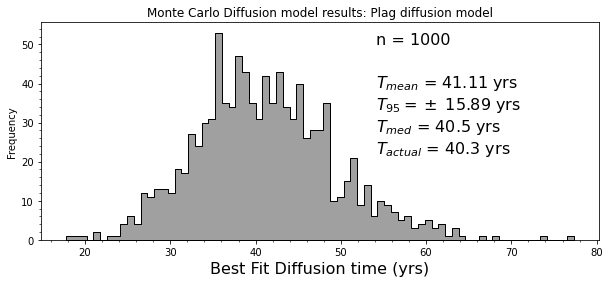

In [13]:
# convert our iterations to years
xx = np.array(best_fits) / makeyears

# if you need to trim some extremely erroneous tails. Sometimes large error bars on one singular
# point will mess up the random profiles.
# you can just filter the array like this:
# x = x[x>100]

# plot up original distribution
fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(xx, bins=75, kde=False, color="gray", ec="k", element="step")
ax.set_title("Monte Carlo Diffusion model results: Plag diffusion model")
ax.set_xlabel("Best Fit Diffusion time (yrs)", fontsize=16)
ax.set_ylabel("Frequency")
ax.text(0.6, 0.9, "n = {}".format(len(xx)), transform=ax.transAxes, fontsize=16)
ax.text(
    0.6,
    0.7,
    "$T_{{mean}}$ = {} yrs".format(np.round(np.mean(xx), 2)),
    transform=ax.transAxes,
    fontsize=16,
)
ax.text(
    0.6,
    0.6,
    "$T_{{95}} = \pm$ {} yrs".format(np.round(1.96 * np.std(xx), 2)),
    transform=ax.transAxes,
    fontsize=16,
)
ax.text(
    0.6,
    0.5,
    "$T_{{med}}$ = {} yrs".format(np.round(np.median(xx), 2)),
    transform=ax.transAxes,
    fontsize=16,
)
# ax.set_xlim(0,8000)
ax.minorticks_on()
# this is manually input after your run the diffusion model based on the measured profile not the random
ax.text(
    0.6,
    0.4,
    "$T_{{actual}}$ = {} yrs".format(np.round(bf_time / makeyears, 2)),
    transform=ax.transAxes,
    fontsize=16,
)

## Transform the data to make it normal
In order for things like the mean and standard deviation to be useful for uncertainties, the data must be normally distributed. To accomplish this we can transform it. Commonly this is either a log transform or square root transform. [This](https://www.statisticssolutions.com/transforming-data-for-normality/) link can help with some explanation on which transform to choose and [this](http://www.biostathandbook.com/transformation.html) link can help with an explanation on back transforms (which can be a little tricky if you log transform your data). I think that both log and sqrt transforms work fairly well here, but the sqrt transform makes the data fit a normal distribution (plotted over the transform for reference) better. Neither are perfect, but they are MUCH better than the original distribution.

In the below plot,the mean, median, 95% confidence limits, and best fit time from above are displayed. 

You now have your best fit diffusion time with calculated uncertainties!

Text(0.5, 1.1, 'Diffusion Model Uncertainty Toba: MQ2')

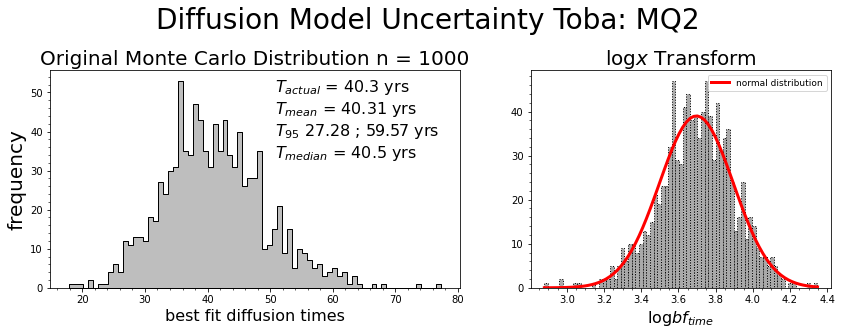

In [15]:
bin_n = 75

# SQUARE ROOT TRANSFORM
# Transforming your data to make it normally distributed
# transform = np.sqrt(x)
# transform_std = np.std(transform)
# transform_mean = np.mean(transform)
# transform_median = np.median(transform)


# #Back calculate mean and standard deviation
# back_all = transform**2
# back_mean = transform_mean**2
# back_median = transform_median**2
# back_std_l = (transform_mean - 1.96*transform_std)**2
# back_std_u = (transform_mean + 1.96*transform_std)**2


# LOG TRANSFORM
# Transforming your data to make it normally distributed
transform = np.log(xx)
transform_std = np.std(transform)
transform_mean = np.mean(transform)
transform_median = np.median(transform)


# Back calculate mean and standard deviation
back_all = np.exp(transform)
back_mean = np.exp(transform_mean)
back_median = np.exp(transform_median)
back_std_l = np.exp(transform_mean - 1.96 * transform_std)
back_std_u = np.exp(transform_mean + 1.96 * transform_std)


fig, ax = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={"width_ratios": [1.5, 1.1],})

sns.histplot(
    back_all, bins=bin_n, color="darkgray", edgecolor="k", element="step", ax=ax[0]
)

ax[0].text(
    0.55,
    0.9,
    "$T_{{actual}}$ = {} yrs".format(np.round(bf_time / makeyears, 2)),
    transform=ax[0].transAxes,
    fontsize=16,
)
ax[0].text(
    0.55,
    0.8,
    "$T_{{mean}}$ = {} yrs".format(np.round(back_mean, 2)),
    transform=ax[0].transAxes,
    fontsize=16,
)
ax[0].text(
    0.55,
    0.7,
    "$T_{{95}}$ {} ; {} yrs".format(np.round(back_std_l, 2), np.round(back_std_u, 2)),
    transform=ax[0].transAxes,
    fontsize=16,
)
ax[0].text(
    0.55,
    0.6,
    "$T_{{median}}$ = {} yrs".format(np.round(back_median, 2)),
    transform=ax[0].transAxes,
    fontsize=16,
)

ax[0].set_ylabel("frequency", fontsize=20)
ax[0].set_xlabel("best fit diffusion times", fontsize=16)
ax[0].set_title("Original Monte Carlo Distribution n = {}".format(len(xx)), fontsize=20)
ax[0].minorticks_on()

# histogram for the transformed data


# Goes into the height array and finds the value that is neares the transform mean
# To get one singular number, just change the value that gets multiplied by "transform_mean"
#'e.g.' .99*transform_mean
# histogram for the transformed data
h2, bins2, patches2 = ax[1].hist(
    transform, bins=bin_n, color="darkgray", edgecolor="k", ls=":"
)


multiply = h2[
    np.where(
        np.logical_and(bins2 > 0.995 * transform_mean, bins2 < 1.0 * transform_mean)
    )
]
# create normal distribution based on your transform mean, std dev, and the bin locations as the x array
normal_dist = (1 / transform_std * np.sqrt(2 * np.pi)) * np.exp(
    -0.5 * ((bins2 - transform_mean) / transform_std) ** 2
)

# scale the normal distribution to match the height of your histogram
normal_dist_scaled = normal_dist * multiply / np.max(normal_dist)


ax[1].plot(bins2, normal_dist_scaled, c="r", lw=3, label="normal distribution")
# ax[1].set_xlabel('$\sqrt{bf_{time}}$',fontsize = 16)
ax[1].set_xlabel("$\log{bf_{time}}$", fontsize=16)

ax[1].minorticks_on()
# ax[1].set_title('$\sqrt{x}$ Transform',fontsize = 20)
ax[1].set_title("$\log{x}$ Transform", fontsize=20)


ax[1].legend(loc="upper right", fontsize=9)
fig.suptitle("Diffusion Model Uncertainty Toba: {}".format(grain), y=1.1, fontsize=28)
